# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

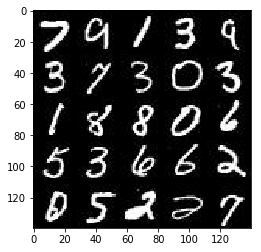

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

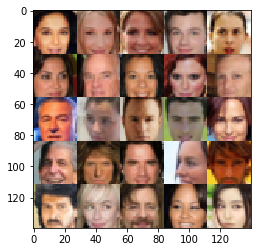

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, (None))

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.1
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    gen = generator(input_z, out_channel_dim)

    _, d_logits_real = discriminator(input_real)
    _, d_logits_fake = discriminator(gen, reuse=True)
    
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    train_d_opt, train_g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2

                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))

                _ = sess.run(train_d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(train_g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 6.4413
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 2.2688
Epoch 1/2... Discriminator Loss: 1.5784... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 0.7053... Generator Loss: 1.4486
Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 2.5071
Epoch 1/2... Discriminator Loss: 4.7935... Generator Loss: 0.0309
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.4790
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 1.7265
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.0492


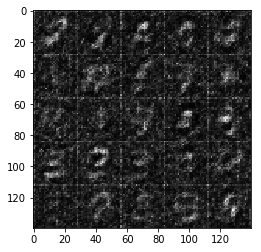

Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 3.3503
Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 2.7393
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 2.9488
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 3.4296
Epoch 1/2... Discriminator Loss: 0.7187... Generator Loss: 1.6516
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.4048
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 2.4487
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.7549


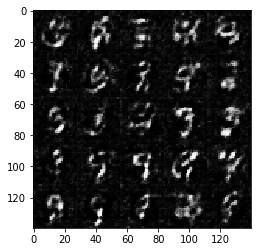

Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 1.7523
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.8650
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.4911
Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 3.0076
Epoch 1/2... Discriminator Loss: 2.1153... Generator Loss: 0.3839
Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 2.2340
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 2.9487
Epoch 1/2... Discriminator Loss: 1.8846... Generator Loss: 5.2175
Epoch 1/2... Discriminator Loss: 0.7158... Generator Loss: 1.5934
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 2.1936


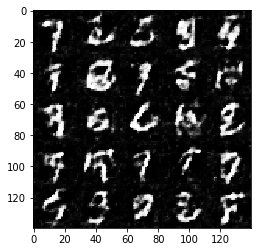

Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 2.4814
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.4170
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 2.2026
Epoch 1/2... Discriminator Loss: 0.5997... Generator Loss: 2.9099
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 1.8172
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 2.7942
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 1.2255
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.9156
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.8830


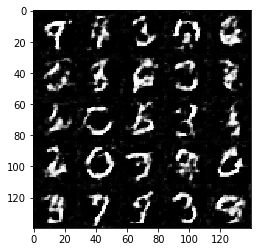

Epoch 1/2... Discriminator Loss: 0.5798... Generator Loss: 2.0058
Epoch 1/2... Discriminator Loss: 0.5063... Generator Loss: 2.6537
Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 1.5878
Epoch 1/2... Discriminator Loss: 0.6161... Generator Loss: 2.2496
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 2.2520
Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 2.4833
Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 2.2878
Epoch 1/2... Discriminator Loss: 0.5727... Generator Loss: 2.4800
Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 2.6372
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 4.4531


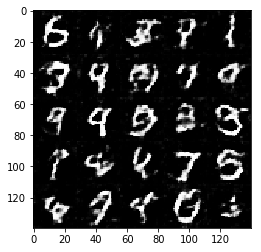

Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 2.1551
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 1.7099
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 1.4963
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 2.7773
Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 2.3094
Epoch 1/2... Discriminator Loss: 1.7226... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 0.5236... Generator Loss: 2.6597


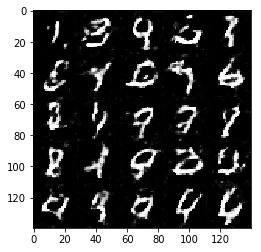

Epoch 1/2... Discriminator Loss: 0.6877... Generator Loss: 1.5131
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 2.2337
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 2.3663
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 2.3092
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 2.3143
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 2.5010
Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 2.1729
Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 2.9168


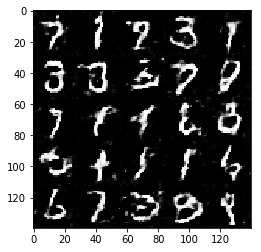

Epoch 1/2... Discriminator Loss: 0.6484... Generator Loss: 1.8515
Epoch 1/2... Discriminator Loss: 0.6170... Generator Loss: 2.1903
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.7046... Generator Loss: 1.5486
Epoch 1/2... Discriminator Loss: 0.5139... Generator Loss: 3.0554
Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 3.6228
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 2.4729
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 3.0426
Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 3.6065
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.6526


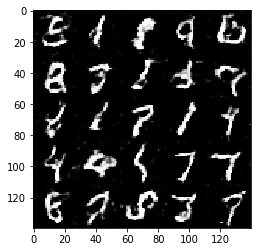

Epoch 1/2... Discriminator Loss: 1.8592... Generator Loss: 5.6993
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.7432
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 2.8814
Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 2.5151
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 3.6530
Epoch 1/2... Discriminator Loss: 0.4896... Generator Loss: 2.8602
Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 2.6215
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 3.0821
Epoch 1/2... Discriminator Loss: 0.4643... Generator Loss: 3.1885
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 2.3598


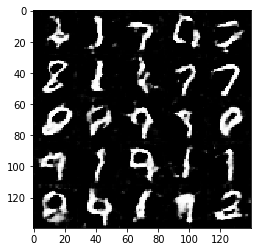

Epoch 1/2... Discriminator Loss: 1.9652... Generator Loss: 4.5118
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 1.6700
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 2.3789
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 2.1270
Epoch 2/2... Discriminator Loss: 0.6156... Generator Loss: 1.7229
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 3.8565
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 3.5663
Epoch 2/2... Discriminator Loss: 0.4232... Generator Loss: 3.0848
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 2.3870
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 2.0242


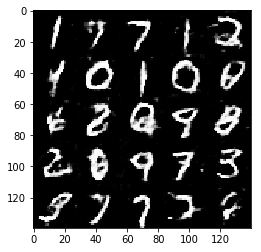

Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 2.0798
Epoch 2/2... Discriminator Loss: 0.5082... Generator Loss: 2.6767
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.8351
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 3.5371
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.6615
Epoch 2/2... Discriminator Loss: 2.2515... Generator Loss: 5.3560
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 1.5900
Epoch 2/2... Discriminator Loss: 0.4870... Generator Loss: 3.3656
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 3.3541
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 3.0237


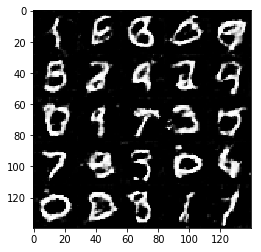

Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 3.7506
Epoch 2/2... Discriminator Loss: 0.5206... Generator Loss: 2.2283
Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 3.0515
Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 3.2845
Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 2.3177
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 4.0162
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 3.0085
Epoch 2/2... Discriminator Loss: 0.4587... Generator Loss: 3.3108
Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 2.7361
Epoch 2/2... Discriminator Loss: 0.4230... Generator Loss: 3.3071


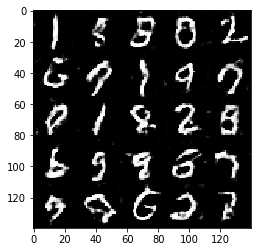

Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 5.5593
Epoch 2/2... Discriminator Loss: 0.4605... Generator Loss: 2.9996
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 1.1605
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.4426
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 3.8118
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 1.4259
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 4.5592
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 3.2295
Epoch 2/2... Discriminator Loss: 0.5706... Generator Loss: 3.2981


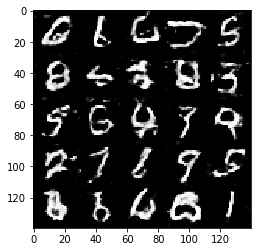

Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 3.8012
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 2.7039
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 2.0287
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 5.3024
Epoch 2/2... Discriminator Loss: 0.4657... Generator Loss: 3.5104
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 2.6107
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 3.4053
Epoch 2/2... Discriminator Loss: 0.4714... Generator Loss: 3.2112
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 3.7672
Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 2.8067


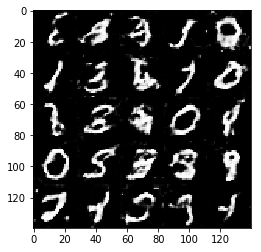

Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 4.2880
Epoch 2/2... Discriminator Loss: 0.4549... Generator Loss: 3.0607
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 2.0688
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 3.5090
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 3.6091
Epoch 2/2... Discriminator Loss: 0.4099... Generator Loss: 3.9206
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 2.7499
Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 3.9474
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 2.4978
Epoch 2/2... Discriminator Loss: 0.4215... Generator Loss: 4.1765


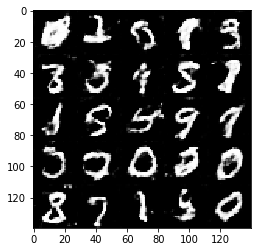

Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 3.7622
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 3.3269
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 1.5864
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 2.7129
Epoch 2/2... Discriminator Loss: 0.5276... Generator Loss: 2.3247
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 3.7950
Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 3.7528
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 5.5944
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 3.2425


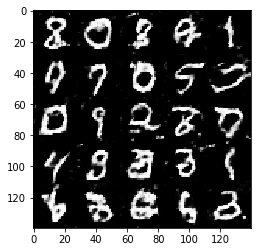

Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 2.9683
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 3.1336
Epoch 2/2... Discriminator Loss: 0.4077... Generator Loss: 3.7329
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 4.4442
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 3.8795
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 4.3419
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 4.2873
Epoch 2/2... Discriminator Loss: 0.4140... Generator Loss: 3.2461
Epoch 2/2... Discriminator Loss: 0.3953... Generator Loss: 3.7544
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 3.6665


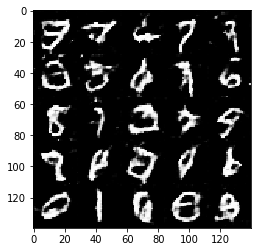

Epoch 2/2... Discriminator Loss: 0.4379... Generator Loss: 3.2388
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 3.5271
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 4.2259
Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 2.7626
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 2.9600
Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 4.5926
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 4.2496
Epoch 2/2... Discriminator Loss: 0.4525... Generator Loss: 3.0024
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 4.5316
Epoch 2/2... Discriminator Loss: 0.4657... Generator Loss: 3.0852


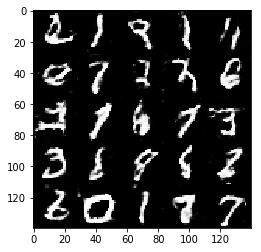

Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 4.7180
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 2.3560
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 2.0071
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 3.7238
Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 3.0359
Epoch 2/2... Discriminator Loss: 0.4564... Generator Loss: 4.0104
Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 3.8624


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 10.3124
Epoch 1/1... Discriminator Loss: 2.6976... Generator Loss: 0.2003
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 2.4722
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 2.1687
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.9176
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 4.5558
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 2.0021... Generator Loss: 0.3262


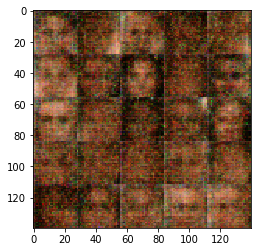

Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 2.7645
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.8889
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 2.5334
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 3.0768
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 3.2942
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.0411
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 2.9721
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 1.8625


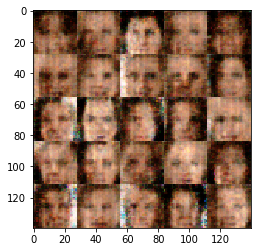

Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.7713
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.8452
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 2.0891
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.4959


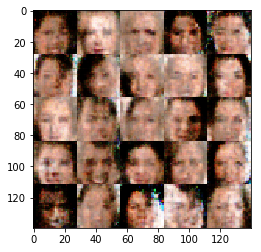

Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 2.2285
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.6651
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 2.4031
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.9559


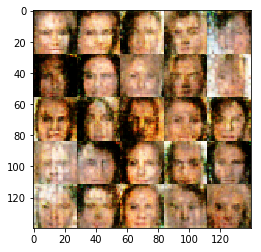

Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 2.3228
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 2.9894
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.7959
Epoch 1/1... Discriminator Loss: 2.5503... Generator Loss: 4.1938
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.7530


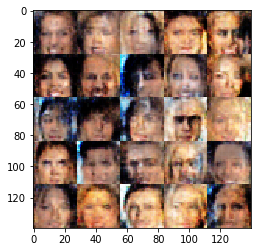

Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.6864
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 2.9864
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 2.5851
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 2.8105


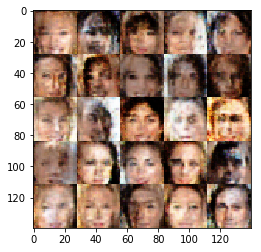

Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.8311
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 3.1941
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.6250


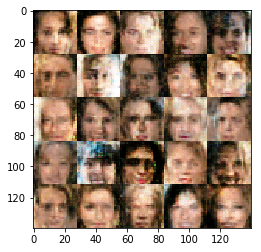

Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.8731
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.7828
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 2.1010
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 2.8690
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.5680
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 2.2995
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 3.1820
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 3.4363
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 2.4660


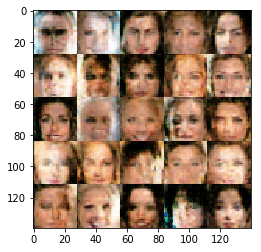

Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 2.2341
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.9727
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.3346
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.8795
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.8884
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 2.0305
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 3.0269


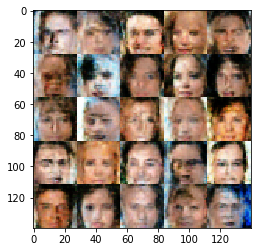

Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 2.4625
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 2.2332
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 1.7941
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.4117
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.9470
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.7410


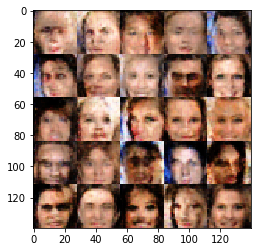

Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 2.0031... Generator Loss: 0.3299
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.7073
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.8682
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 1.3848


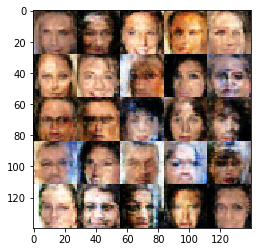

Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 3.3411
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 2.9426
Epoch 1/1... Discriminator Loss: 2.2920... Generator Loss: 3.5432
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 1.4994
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 2.5510
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 2.5734
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 2.5907
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 1.8450


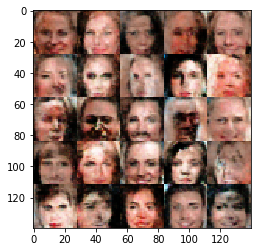

Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 2.0519
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 2.8402
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.3013
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.5149
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.9246


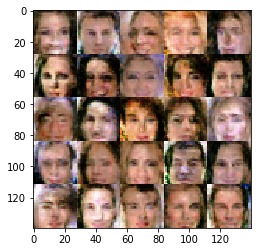

Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 2.5902
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 2.2434
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.6843
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.9601
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 2.2543
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.8364
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 4.0872
Epoch 1/1... Discriminator Loss: 3.1843... Generator Loss: 6.4765
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 2.2953


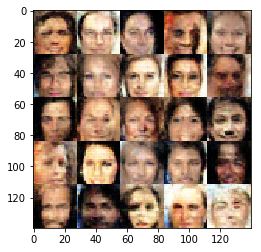

Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 3.2251
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 3.3253
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 3.5181
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.5497
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 2.2923
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 2.7025
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 2.4274


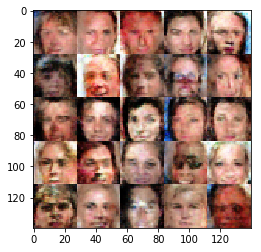

Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 3.1064
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.8622
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 2.2582
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 3.6013
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 2.3502
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 2.9732
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 3.3015
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.2688
Epoch 1/1... Discriminator Loss: 1.9122... Generator Loss: 0.4147


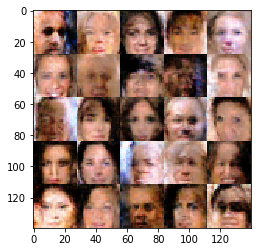

Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 3.2084
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 2.2404
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.2704
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.6473
Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 3.0788
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 3.3241
Epoch 1/1... Discriminator Loss: 4.7408... Generator Loss: 8.1672
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 2.0691
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7387


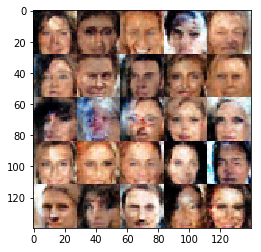

Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.5430
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 3.5186
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 3.4716
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.0708
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 2.1188
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.6633
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.8643
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 4.0772
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 3.4459


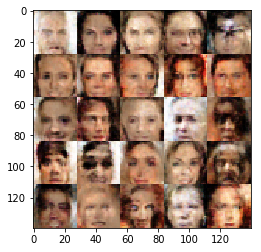

Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 2.7727
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.9741... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 3.1108
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.5200
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 4.0878
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 3.4456


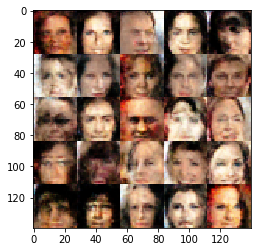

Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 2.4111
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 3.3386
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 4.0133
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 4.8115
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 3.6544
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 3.4833
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 4.5935
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 3.8827
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 3.4242
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 1.8210


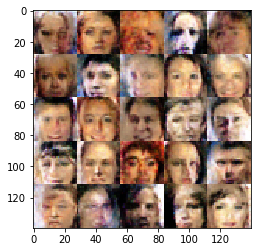

Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 2.8812
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.9543
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 2.8743
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 4.8866
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 4.9144
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.4599
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.9126
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 3.4865
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 2.8398
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 3.9561


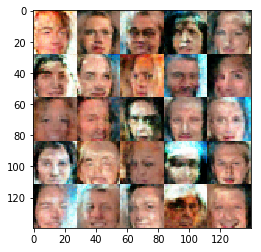

Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 3.0105
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 3.4854
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 4.0422
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 4.0686
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.1129
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 3.3945
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 3.5261
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 2.0164


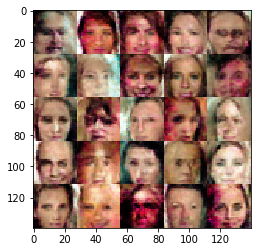

Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 3.4175
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 4.9038
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 4.0048
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 2.1876
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 3.6047
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.9923
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.8775
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 3.9969
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 3.3273


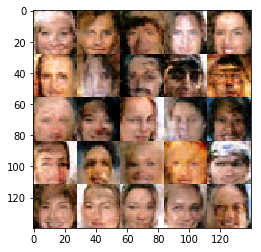

Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 4.0026
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.9199
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.8034
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.1122
Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 3.5151
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 2.6657
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 3.2102
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 5.3690
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 3.4557
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 3.0361


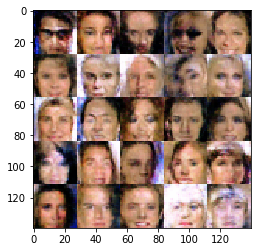

Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 4.7207
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 4.1417
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.8048
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.8556
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 3.2984
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 5.2084
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.7372
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.4251
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.8443
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.9404


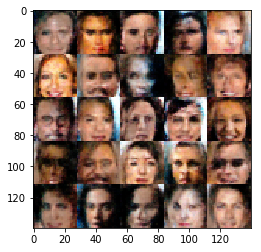

Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 3.8072
Epoch 1/1... Discriminator Loss: 2.2062... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 1.9935
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.4379
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.4236
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.8082
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 3.1578
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 3.5140


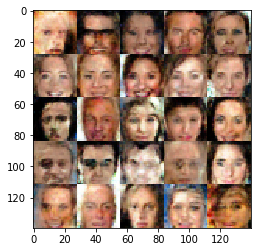

Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 3.6833
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.1899
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 3.4062
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 3.1123
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.5815
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 4.8042
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 4.0715
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.2278
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 4.4236
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 3.4500


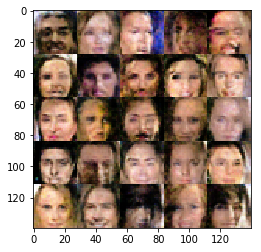

Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 4.5968
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.7230
Epoch 1/1... Discriminator Loss: 2.0461... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 3.4087
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 3.8739
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.4673
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.6618
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.7623


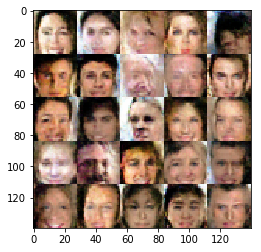

Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 4.7572
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 4.1144
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 2.5693
Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 3.4325
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 3.5670
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.4780


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.